In [1]:
import pandas as pd
from matplotlib import pyplot as plt

Exploratory analysis on the original annotations

We have a long-tail issue with classes that only appear in one or two clips. Due to the limitations of our model and the fact that it is not time aware, parking or picking up a bike are not truly different to holding. We choose to change those annotations.
At this point we also change our only instance of 'human-walk-motorcycle' as it is wrong, and we remove vehicles. These changes need to happen in the original dataset

In [2]:
#Loading and merging all annotations
data_org = pd.read_csv('data_anno/annotations_hoi_frame_jacob.csv', sep=',')
data_org = pd.concat((data_org, pd.read_csv('data_anno/annotations_hoi_frame_741.csv', sep=',')))
data_org = pd.concat((data_org, pd.read_csv('data_anno/annotations_hoi_frame_742.csv', sep=',')))

#Replace rare actions
data_org = data_org[data_org['object_class'] != 'vehicle']
data_org = data_org.replace(('pickup', 'park'), 'hold')
data_org.loc[(data_org['action']=='walk') & (data_org['object_class']=='motorcycle'), 'object_class'] = 'bicycle'
data_org["id"] = data_org.groupby(data_org[["human_id", "object_id", 'action']].apply(frozenset, axis=1)).ngroup()
data = data_org.copy()

#Define unique interactions by identifying all unique combinations of human_id, object_id and action
data["id"] = data.groupby(data[["human_id", "object_id", 'action']].apply(frozenset, axis=1)).ngroup()
data = data.drop_duplicates(subset='id').drop(['frame_id'], axis=1)

#Create a class column 
data['class'] = 'human-'+data['action']+'-'+data['object_class']


Text(0, 0.5, 'counts')

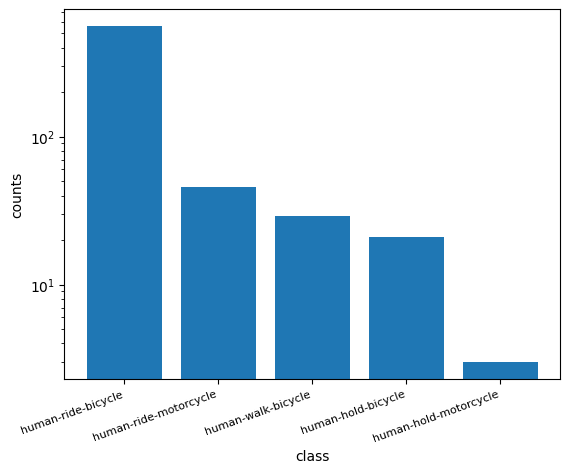

In [3]:
plt.bar(data['class'].value_counts().index, data['class'].value_counts())
plt.xticks(rotation=20, ha='right', fontsize=8)
plt.yscale('log')
plt.xlabel('class')
plt.ylabel('counts')

We attempt a stratified split

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[:-1]], data[data.columns[-1]], test_size=0.33, stratify=data[data.columns[-1]], random_state=42)

In [5]:
X_train['id'].unique()

training_data = data_org[data_org['id'].isin(X_train['id'].unique())]
testing_data = data_org[data_org['id'].isin(X_test['id'].unique())]

training_data.drop(['id'], axis=1).to_csv(r'data_anno\training_data.csv', sep=',')
testing_data.drop(['id'], axis=1).to_csv(r'data_anno\testing_data.csv', sep=',')